In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import json
import os

In [2]:
!pip install  scikit-allel

     |████████████████████████████████| 5.7 MB 3.5 MB/s 


In [3]:
!pip install pyBigWig

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for pyBigWig: filename=pyBigWig-0.3.18-cp37-cp37m-linux_x86_64.whl size=194122 sha256=25d8b92b035b7f6d1fb74174fd92acb68bdfb9b861c5b306b00a51f0d0e859b9
  Stored in directory: /root/.cache/pip/wheels/28/eb/46/c761563ba38bd516bcc6accde3d4188cd84eec067f9201cbec
Successfully built pyBigWig


In [5]:

import allel
import pyBigWig
from google.colab import drive
drive.mount('/content/drive/')

parent_dir_name = 'CS194-172 Final Project'

for dirpath, subdirs, files in os.walk('/content/'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/.shortcut-targets-by-id/1bNsJ-cxXG0DtLjAAE_uUPJ7L_GkhuM_i/CS194-172 Final Project'

In [6]:
clinvar = allel.vcf_to_dataframe(parent_path + '/clinvar.vcf', fields='*', alt_number=1)
clinvar["variant type"] = clinvar["MC"].apply(lambda row: str(row)[str(row).find("|")+1:])

In [7]:
intron = clinvar[(clinvar["variant type"] == "intron_variant")]

In [8]:
#Keep pathogenic and benign variants only, assign class label of 1 to pathogenic and 0 to benign
intron = intron[(intron['CLNSIG'] == 'Pathogenic') | (intron['CLNSIG'] == 'Benign')]
intron['Class label']= np.where(intron['CLNSIG']=='Pathogenic', 1, 0)
intron_benign = intron[intron['CLNSIG']== 'Benign'].iloc[:1299]
intron_pathogenic =intron[intron['CLNSIG']== 'Pathogenic'].iloc[:1299]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
intron = pd.concat([intron_benign, intron_pathogenic])

In [52]:
intron

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label
36,1,935766,1169977,C,T,NaN,NaN,NaN,NaN,1153707,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935766C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0
61,1,939035,1166157,C,T,NaN,NaN,NaN,NaN,1153713,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939035C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0
78,1,939146,1167425,G,C,NaN,NaN,NaN,NaN,1153714,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939146G>C,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0
137,1,942265,1164166,T,G,NaN,NaN,NaN,NaN,1153721,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942265T>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0
139,1,942402,1170012,C,G,NaN,NaN,NaN,NaN,1153722,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942402C>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54413,X,154879651,973791,AGG,CCT,NaN,NaN,NaN,NaN,962111,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154879651_154879653inv,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Inversion,SO:1000036,NaN,NaN,F8:2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,False,intron_variant,1
54633,X,154947224,503494,GAAAAAAAAAAAAA,G,NaN,NaN,NaN,NaN,494917,Mild_hemophilia_A,NaN,MONDO:MONDO:0015721,NaN,NC_000023.11:g.154947237_154947249del,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,OMIM_Allelic_Variant:300841.0271,NaN,F8:2157,SO:0001627|intron_variant,1,781928603,-1,False,1,-13,False,intron_variant,1
54775,X,154984684,10183,T,C,NaN,NaN,NaN,NaN,25222,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154984684T>C,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,F8_@_LOVD:F8_000874|OMIM_Allelic_Variant:30084...,NaN,F8:2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,1
54789,X,154991304,10097,C,T,NaN,NaN,NaN,NaN,25136,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154991304C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:300841.0013,NaN,F8:2157,SO:0001627|intron_variant,1,387906429,-1,False,1,0,True,intron_variant,1


**Part 1: Features Selection** 
- RVIS Score
-PhastCons Value 
-O/E Value 
-Exac_pLI Value 
-Xpresso
-GDI Index
-CADD Score

**RVIS Score**



In [10]:
#Read data set and drop unnecessary columns 
rvis_data = pd.read_csv(parent_path + '/RVIS_Unpublished_ExACv2_March2017.txt', delimiter="\t")
rvis_data = rvis_data.drop(columns=['%geneCov', 'RVIS[pop_maf_0.05%(any)]', 'Edge_case_RVIS[pop_maf_0.05%(any)]', 'OE-ratio_[ExAC v2]', 'alternative-RVIS[maf_0.0025%]', 'alternative-%RVIS[maf_0.0025%]', '%OE-ratio_[ExAC v2]'])
rvis_data = rvis_data.set_index("CCDSr20")

#Clean up GENEINFO column to merge rviz values 
intron['GENEINFO'] = intron['GENEINFO'].str.replace(':', ' ')
intron['GENEINFO'] = intron['GENEINFO'].str.replace('|', ' ')
intron[['GENE1', 'NUM1', 'GENE2', 'NUM2']] =  intron['GENEINFO'].str.split(' ', 3, expand=True)

intron = pd.merge(intron, rvis_data, left_on="GENE1", right_on="CCDSr20", how="left")
intron['%RVIS[pop_maf_0.05%(any)]'] = intron['%RVIS[pop_maf_0.05%(any)]'].replace(np.nan, 50)
intron= intron.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "first rvis"})
intron = pd.merge(intron, rvis_data, left_on="GENE2", right_on="CCDSr20", how="left")
intron= intron.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "second rvis"})
intron["second rvis"] = intron[intron['GENE2'].values != None]["second rvis"].replace(np.nan, 50)

#Take average of gene1 and gene2 rvis values 
intron["mean RVIS score"] =  intron[["first rvis", "second rvis"]].mean(axis=1)


Text(0.5, 1.0, 'RVIS')

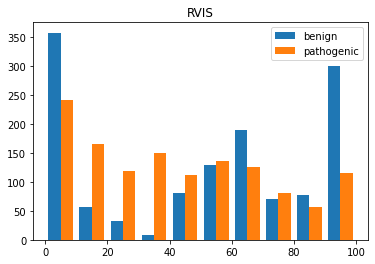

In [11]:
#plot histogram 
pathogenic = intron[intron['Class label']== 1]
benign = intron[intron['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['mean RVIS score'], pathogenic['mean RVIS score']], label=names)
plt.legend()
plt.title("RVIS")

**PhastCons Value**

In [12]:
#Extract phastCons data and append it to variants
phastcons_data = pyBigWig.open(parent_path + "/hg38.phastCons100way.bw")
intron["phastCons"] = [phastcons_data.stats("chr" + x, y, y+1) for x, y in zip(intron["CHROM"],intron["POS"])]
intron["phastCons"] = intron["phastCons"].str[0]

Text(0.5, 1.0, 'PhastCons')

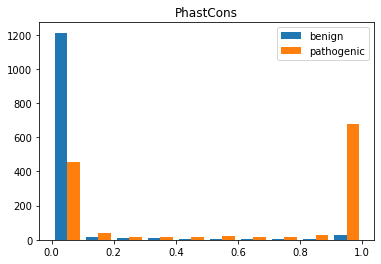

In [56]:
#Plot a histogram
pathogenic = intron[intron['Class label']== 1]
benign = intron[intron['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['phastCons'], pathogenic['phastCons']], label=names)
plt.legend()
plt.title("PhastCons")

**O/E Value and 
Exac_pLI Value**

In [13]:
#Extract gnomad data and append values to variants
gnomad_data = pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
intron = pd.merge(intron, gnomad_data, left_on="GENE1", right_on="gene", how="left")
intron["oe_lof_upper_rank"] = intron["oe_lof_upper_rank"].replace(np.nan, intron["oe_lof_upper_rank"].max()/2)
intron["exac_pLI"] = intron["exac_pLI"].replace(np.nan, intron["exac_pLI"].max()/2)


In [14]:
pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')


,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,possible_mis_pphen,obs_syn,exp_syn,oe_syn,mu_syn,possible_syn,obs_lof,mu_lof,possible_lof,exp_lof,pLI,pNull,pRec,oe_lof,oe_syn_lower,oe_syn_upper,oe_mis_lower,oe_mis_upper,oe_lof_lower,oe_lof_upper,constraint_flag,syn_z,mis_z,lof_z,oe_lof_upper_rank,oe_lof_upper_bin,oe_lof_upper_bin_6,n_sites,classic_caf,max_af,no_lofs,obs_het_lof,obs_hom_lof,defined,p,exp_hom_lof,classic_caf_afr,classic_caf_amr,classic_caf_asj,classic_caf_eas,classic_caf_fin,classic_caf_nfe,classic_caf_oth,classic_caf_sas,p_afr,p_amr,p_asj,p_eas,p_fin,p_nfe,p_oth,p_sas,transcript_type,gene_id,transcript_level,cds_length,num_coding_exons,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,6708.0,422,387.530,1.08900,0.000019,4248,0.0,0.000005,1257.0,98.429,1.0,8.943600e-40,1.838300e-16,0.000000,1.005,1.180,0.736,0.824,0.000,0.030,NaN,-1.376500,2.623200,9.1935,0.0,0.0,0.0,2.0,0.000012,0.000008,124782.0,3.0,0.0,124785.0,0.000012,0.000018,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,protein_coding,ENSG00000108510,2,6522,30,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,7135.0,496,495.010,1.00200,0.000025,5211,1.0,0.000009,1781.0,150.320,1.0,2.977300e-59,3.572400e-24,0.006653,0.930,1.079,0.554,0.621,0.001,0.032,NaN,-0.035119,5.573700,11.2860,1.0,0.0,0.0,2.0,0.000012,0.000008,125693.0,3.0,0.0,125696.0,0.000012,0.000018,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,protein_coding,ENSG00000164190,2,8412,46,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,2197.0,215,203.250,1.05780,0.000010,2091,0.0,0.000005,937.0,79.490,1.0,2.785300e-32,2.191400e-13,0.000000,0.946,1.184,0.249,0.320,0.000,0.037,NaN,-0.647760,6.399900,8.2618,2.0,0.0,0.0,8.0,0.000032,0.000004,125731.0,8.0,0.0,125739.0,0.000032,0.000127,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,protein_coding,ENSG00000108055,2,3651,29,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,3560.0,470,456.030,1.03060,0.000024,4564,1.0,0.000007,1440.0,125.030,1.0,2.992400e-49,4.562900e-20,0.007998,0.955,1.112,0.403,0.464,0.002,0.038,NaN,-0.514100,7.254600,10.2790,3.0,0.0,0.0,5.0,0.000020,0.000004,125740.0,4.0,0.0,125744.0,0.000016,0.000032,0.000000,0.000029,0.000000,0.000055,0.000000,0.000026,0.0,0.000000,0.000000,0.000029,0.000000,0.000054,0.000000,0.000018,0.0,0.000000,protein_coding,ENSG00000125107,2,7128,48,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,4151.0,358,352.620,1.01530,0.000017,3482,0.0,0.000004,1024.0,73.222,1.0,8.405500e-30,2.284200e-12,0.000000,0.930,1.108,0.645,0.733,0.000,0.040,NaN,-0.225180,3.462000,7.9294,4.0,0.0,0.0,1.0,0.000004,0.000004,125122.0,1.0,0.0,125123.0,0.000004,0.000002,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,protein_coding,ENSG00000117000,2,5742,8,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [16]:
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
intron = pd.merge(intron, gnomad_data, left_on="GENE1", right_on="gene", how="left")
intron["oe_lof_upper_rank"] = intron["oe_lof_upper_rank"].replace(np.nan, intron["oe_lof_upper_rank"].max()/2)
intron["exac_pLI"] = intron["exac_pLI"].replace(np.nan, intron["exac_pLI"].max()/2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'O/E')

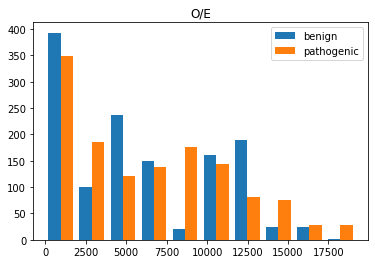

In [17]:
#Plot histograms
pathogenic = intron[intron['Class label']== 1]
benign = intron[intron['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['oe_lof_upper_rank'], pathogenic['oe_lof_upper_rank']], label=names)
plt.legend()
plt.title("O/E")


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'exac_pLI')

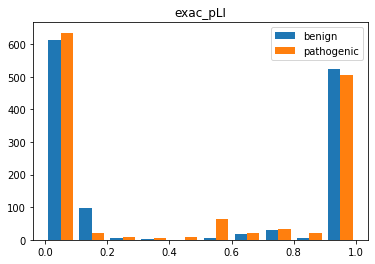

In [18]:
#Plot histograms
pathogenic = intron[intron['Class label']== 1]
benign = intron[intron['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign["exac_pLI"], pathogenic["exac_pLI"]], label=names)
plt.legend()
plt.title("exac_pLI")

In [19]:
intron

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI
0,1,935766,1169977,C,T,NaN,NaN,NaN,NaN,1153707,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935766C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10
1,1,939035,1166157,C,T,NaN,NaN,NaN,NaN,1153713,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939035C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10
2,1,939146,1167425,G,C,NaN,NaN,NaN,NaN,1153714,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939146G>C,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10
3,1,942265,1164166,T,G,NaN,NaN,NaN,NaN,1153721,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942265T>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10
4,1,942402,1170012,C,G,NaN,NaN,NaN,NaN,1153722,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942402C>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,X,154879651,973791,AGG,CCT,NaN,NaN,NaN,NaN,962111,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154879651_154879653inv,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Inversion,SO:1000036,NaN,NaN,F8 2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,False,intron_variant,1,F8,2157,None,None,49.843260,NaN,49.843260,0.127,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00
2622,X,154947224,503494,GAAAAAAAAAAAAA,G,NaN,NaN,NaN,NaN,494917,Mild_hemophilia_A,NaN,MONDO:MONDO:0015721,NaN,NC_000023.11:g.154947237_154947249del,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,OMIM_Allelic_Variant:300841.0271,NaN,F8 2157,SO:0001627|intron_variant,1,781928603,-1,False,1,-13,False,intron_variant,1,F8,2157,None,None,49.843260,NaN,49.843260,0.113,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00
2623,X,154984684,10183,T,C,NaN,NaN,NaN,NaN,25222,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154984684T>C,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,F8_@_LOVD:F8_000874|OMIM_Allelic_Variant:30084...,NaN,F8 2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,1,F8,2157,None,None,49.843260,NaN,49.843260,1.000,F8,147.0,1.000000e+00,F8,147.0,

**Gene Expression Level**

In [20]:
# from Xpresso dataset
# read by default 1st sheet of an excel file
dataframe1 = pd.read_excel(parent_path + "/xpresso.xlsx")
Xpresso = dataframe1[['Unnamed: 1', 'Unnamed: 63']][2:]
Xpresso = Xpresso.rename(columns={'Unnamed: 1':"Gene Name", 'Unnamed: 63':"Median expression" })[1:]
intron = pd.merge(intron, Xpresso, left_on="GENE1", right_on="Gene Name", how="left")
intron["Median expression"] = intron["Median expression"].replace(np.nan, 0)
intron = intron.rename(columns = {"Median expression": "median_expression_level_1"})

intron = pd.merge(intron, Xpresso, left_on="GENE2", right_on="Gene Name", how="left")
intron["Median expression"] = intron[intron['GENE2'].values != None]["Median expression"].replace(np.nan, 0)
intron = intron.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
intron["mean gene_expression_level"] =  intron[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
intron = intron.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [21]:
intron

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI,mean gene_expression_level
0,1,935766,1169977,C,T,NaN,NaN,NaN,NaN,1153707,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935766C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,0.206
1,1,939035,1166157,C,T,NaN,NaN,NaN,NaN,1153713,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939035C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,0.206
2,1,939146,1167425,G,C,NaN,NaN,NaN,NaN,1153714,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.939146G>C,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,0.206
3,1,942265,1164166,T,G,NaN,NaN,NaN,NaN,1153721,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942265T>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,0.206
4,1,942402,1170012,C,G,NaN,NaN,NaN,NaN,1153722,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.942402C>G,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.000,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,SAMD11,13738.0,1.353800e-10,0.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,X,154879651,973791,AGG,CCT,NaN,NaN,NaN,NaN,962111,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154879651_154879653inv,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Inversion,SO:1000036,NaN,NaN,F8 2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,False,intron_variant,1,F8,2157,None,None,49.843260,NaN,49.843260,0.127,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,-0.148
2622,X,154947224,503494,GAAAAAAAAAAAAA,G,NaN,NaN,NaN,NaN,494917,Mild_hemophilia_A,NaN,MONDO:MONDO:0015721,NaN,NC_000023.11:g.154947237_154947249del,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,OMIM_Allelic_Variant:300841.0271,NaN,F8 2157,SO:0001627|intron_variant,1,781928603,-1,False,1,-13,False,intron_variant,1,F8,2157,None,None,49.843260,NaN,49.843260,0.113,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,F8,147.0,1.000000e+00,-0.148
2623,X,154984684,10183,T,C,NaN,NaN,NaN,NaN,25222,Hereditary_factor_VIII_deficiency_disease,NaN,MONDO:MONDO:0010602,NaN,NC_000023.11:g.154984684T>C,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,F8_@_LOVD:F8_000874|OMIM_Allelic_Variant:30084...,NaN,F8 2157,SO:0001627|intron_variant,1,NaN,-1,False,1,0,True,intron_variant,1,F8,2

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


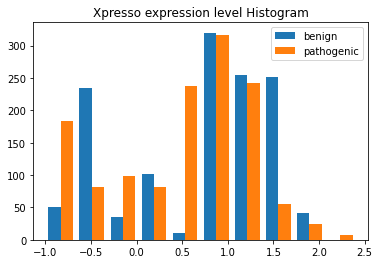

In [22]:
plt.hist([intron[intron["Class label"] == 0 ]["mean gene_expression_level"],intron[intron["Class label"] == 1 ]["mean gene_expression_level"]], label = ["benign", "pathogenic"])  
plt.title('Xpresso expression level Histogram')


plt.legend(loc='upper right')

**GDI Index**

In [23]:
import re
gdi_data = pd.read_csv(parent_path + "/GDI_full.txt",  delimiter="\t")
gdi_data = gdi_data[["Gene", "GDI-Phred"]]
gdi_data = gdi_data.rename(columns={"Gene": "Gene Name", "GDI-Phred":"Median expression"})


intron = pd.merge(intron, gdi_data, left_on="GENE1", right_on="Gene Name", how="left")
intron["Median expression"] = intron["Median expression"].replace(np.nan, intron["Median expression"].max()/2)
intron = intron.rename(columns = {"Median expression": "median_expression_level_1"})

intron = pd.merge(intron, gdi_data, left_on="GENE2", right_on="Gene Name", how="left")
intron["Median expression"] = intron[intron['GENE2'].values != None]["Median expression"].replace(np.nan, intron["Median expression"].max()/2)
intron = intron.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
intron["GDI"] =  intron[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
intron = intron.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [ ]:
intron

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


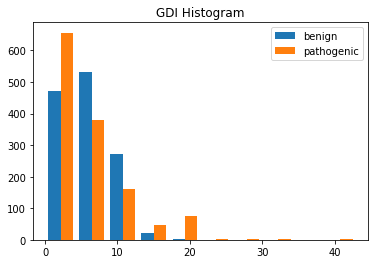

In [24]:
plt.hist([intron[intron["Class label"] == 0 ]["GDI"],intron[intron["Class label"] == 1 ]["GDI"]], label = ["benign", "pathogenic"])  
plt.title('GDI Histogram')


plt.legend(loc='upper right')

**CADD**

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

In [ ]:
intron

1. Create gzipped vcf file, with proper format and without extra data for speed

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

new = intron
new["ALT length"] = new['ALT'].apply(lambda r: len(str(r)))
new["REF length"] = new['REF'].apply(lambda r: len(str(r)))
new = new[(new["ALT length"]==1)]
new = new[(new["REF length"]==1)]


new = new[["CHROM", "POS", "ID", "REF", "ALT"]]
# new["ALT"] = new["ALT"].apply(lambda row: row[0])
header = """##fileformat=VCFv4.1
#CHROM POS ID REF ALT
"""

output_VCF = "intron_data.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

new.to_csv(output_VCF, sep="\t", mode='a', index=False)

# import gzip
# import shutil
# with open('file.txt', 'rb') as f_in:
#     with gzip.open('file.txt.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)


# turn in to # https://cadd.gs.washington.edu/score with ANNOTATIONS selected

2.Upload to https://cadd.gs.washington.edu/score **with ANNOTATIONS selected**
and cadd model GRCh38-v1.6

---



3. Upload resulting file to folder, below code reads as df

In [25]:
import gzip
with gzip.open(parent_path +'/intron_cadd_results.tsv.gz', 'rt') as f:
  # with gzip.open('chr22_subsampled_snps.vcf.gz', 'rt') as f:
  lines = f.readlines()
  with open('caddunzipped.txt', 'w') as t:
    for line in lines[1:]:
        t.write(line)
        t.write('\n')
cadd_data = pd.read_csv('caddunzipped.txt', delimiter="\t")
cadd_data = cadd_data.rename(columns={"PHRED": "CADD_score"})

In [26]:
cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))

cadd_columns = ["CADD_score"]
cadd_data = cadd_data[["#Chrom", "Pos"]+cadd_columns]
cadd_intron_merged = pd.merge(left = intron, right = cadd_data, left_on = ["CHROM", "POS"], right_on=["#Chrom", "Pos"],how="left")
for col in cadd_columns:
  cadd_intron_merged[col] = cadd_intron_merged[col].replace(np.nan, cadd_intron_merged[col].max()/2) 

intron = cadd_intron_merged.drop(columns =["#Chrom", "Pos"])

  

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


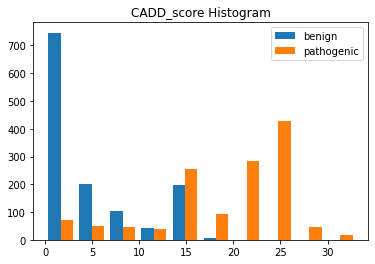

In [27]:
plt.hist([intron[intron["Class label"] == 0 ]["CADD_score"],intron[intron["Class label"] == 1 ]["CADD_score"]], label = ["benign", "pathogenic"])  
plt.title("CADD_score Histogram")


plt.legend(loc='upper right')

Training of Model

In [28]:
intron.columns
c =["CHROM", "POS", "Class label", "mean RVIS score", "phastCons", "oe_lof_upper_rank", "exac_pLI", "GDI", "CADD_score"]
for val in c:
  if val not in intron.columns:
    print(val)

In [29]:
intron_data = intron[c]

In [30]:
intron_data

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score
0,1,935766,0,96.686217,0.000,13738.0,1.353800e-10,5.65821,7.425
1,1,939035,0,96.686217,0.000,13738.0,1.353800e-10,5.65821,1.139
2,1,939146,0,96.686217,0.000,13738.0,1.353800e-10,5.65821,3.039
3,1,942265,0,96.686217,0.000,13738.0,1.353800e-10,5.65821,9.021
4,1,942402,0,96.686217,0.000,13738.0,1.353800e-10,5.65821,8.276
...,...,...,...,...,...,...,...,...,...
2621,X,154879651,1,49.843260,0.127,147.0,1.000000e+00,4.02864,16.500
2622,X,154947224,1,49.843260,0.113,147.0,1.000000e+00,4.02864,16.500
2623,X,154984684,1,49.843260,1.000,147.0,1.000000e+00,4.02864,22.300
2624,X,154991304,1,49.843260,0.003,147.0,1.000000e+00,4.02864,0.944


In [31]:
training_set, validation_set= train_test_split(intron_data, test_size=0.2)

In [32]:
training_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score
1709,6,87569512,1,54.281525,1.000,9745.0,3.494400e-06,6.53435,22.600
1594,3,183025807,1,73.695015,0.192,9481.0,2.511100e-05,13.29903,22.300
114,1,1341550,0,43.773216,0.000,7499.0,1.571600e-01,2.46667,16.500
2512,X,38408798,1,27.899687,0.917,3643.0,9.810200e-01,6.27812,22.800
172,1,3244445,0,48.054741,0.000,939.0,9.998400e-01,6.69837,3.554
...,...,...,...,...,...,...,...,...,...
683,1,10659509,0,18.533724,0.001,576.0,9.999400e-01,6.31123,0.003
1967,11,46900387,1,3.822092,0.000,3771.0,1.002100e-01,21.64220,13.660
884,1,11797731,0,74.467253,0.003,9733.0,2.455200e-07,13.51805,4.456
891,1,11802721,0,74.467253,0.000,9733.0,2.455200e-07,13.51805,0.926


In [33]:
validation_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score
1885,9,127843089,1,62.189638,1.000,1537.0,9.896200e-01,3.61548,23.100
265,1,3831016,0,93.304008,0.000,7639.0,2.630800e-08,9.37024,0.191
234,1,3823670,0,93.304008,0.000,7639.0,2.630800e-08,9.37024,0.166
2407,19,36097084,1,46.060606,1.000,8977.0,3.701500e-13,4.64667,23.100
2321,17,43067700,1,64.877810,1.000,9629.0,3.287400e-20,12.15413,23.300
...,...,...,...,...,...,...,...,...,...
2202,16,89782938,1,46.441838,0.000,14519.0,2.081200e-34,7.80511,0.025
2192,16,88810067,1,68.729228,1.000,19084.0,4.718200e-10,1.40998,22.100
226,1,3816032,0,93.304008,0.000,7639.0,2.630800e-08,9.37024,1.630
1615,4,102579043,1,22.375367,1.000,475.0,9.942600e-01,1.95667,25.000


In [43]:
X_train = training_set.drop(columns=["Class label", "CHROM", "POS"]).fillna(0)
Y_train = training_set.loc[:, training_set.columns.intersection(['Class label'])]
X_test = validation_set.drop(columns=["Class label", "CHROM", "POS"])
Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]

In [45]:
estimators = [50, 100, 150, 200, 250, 300, 350]
kf =KFold(n_splits=5, shuffle=True, random_state=42)
for count in estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= count, random_state= 42), X_train, Y_train, cv= kf, scoring= "accuracy")
    print(f'For estimators: {count}')
    print(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 50
0.9533333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 100
0.9519047619047619


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 150
0.9519047619047619


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 200
0.9523809523809523


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 250
0.9523809523809523


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 300
0.9523809523809523


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 350
0.9528571428571428


In [46]:
model = RandomForestClassifier(n_estimators= 50)

In [47]:
model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(n_estimators=50)

In [48]:

Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]
accuracy_score(model.predict(X_test), Y_test)

0.9467680608365019

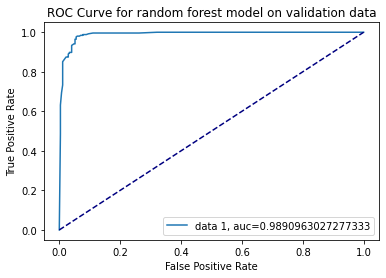

In [49]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color="navy",linestyle="--")
plt.title("ROC Curve for random forest model on validation data")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

**Testing INTRON variant model on frameshift variants to see if model learnings are transferable across varaint types**


In [56]:
export_frameshift_y_test = pd.read_csv(parent_path + '/export_frameshift_y_test.csv', delimiter="\t").drop(columns = ["Unnamed: 0"])
export_frameshift_x_test = pd.read_csv(parent_path + '/export_frameshift_x_test.csv', delimiter="\t").drop(columns = ["Unnamed: 0"])



In [59]:
accuracy_score(model.predict(export_frameshift_x_test), export_frameshift_y_test)

0.5859375